<h1><b>Image Captioning using Encoder & Decoder Model

Installing "ipython-autotime" to keep track of time for each cell

In [0]:
pip install ipython-autotime

# Importing Libraries

In [0]:
%%time
import pandas as pd
import numpy as np
import os
from os import path
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.models import *
from keras.layers import *
from keras.layers.merge import add
from keras.utils import to_categorical
import pickle
from pickle import dump, load
import tensorflow as tf
from keras import optimizers
import random
import keras.backend as K
import matplotlib.pyplot as plt
from keras import regularizers

Using TensorFlow backend.


CPU times: user 1.81 s, sys: 160 ms, total: 1.97 s
Wall time: 2.03 s


### Getting the file Path of Annotation file and Image Directory

In [0]:
%%time
annot_file_path = '/content/drive/My Drive/Colab Notebooks/flickr8k/Flickr8k.token.txt'
image_dir_path = '/content/drive/My Drive/Colab Notebooks/flickr8k/Images/'

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


### Loading the annot file as csv with '\t' (tab) as seperator, and manually assigning Column names as 'filename' and 'caption'

In [0]:
%%time
data = pd.read_csv(annot_file_path,sep='\t',names=['filename','caption'])

CPU times: user 50.1 ms, sys: 19 ms, total: 69.1 ms
Wall time: 76.5 ms


#### Removing '.jpg#number' from the values so we get same values for images

In [0]:
%%time
data['filename'] = data['filename'].str.replace('#\d','')

CPU times: user 41.9 ms, sys: 992 µs, total: 42.9 ms
Wall time: 42.4 ms


In [0]:
%%time
data.head()

CPU times: user 610 µs, sys: 89 µs, total: 699 µs
Wall time: 689 µs


filename                                            caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...

In [0]:
%%time
print('Total Number of Unique Images in the Annotation Files : ',data.filename.nunique())

Total Number of Unique Images in the Annotation Files :  8092
CPU times: user 6.5 ms, sys: 1.07 ms, total: 7.57 ms
Wall time: 7.28 ms


#### Checking the number of files in the Image dir, to make sure that we are not having mismatch of data.

In [0]:
%%time
print('Total Number of Images in the Image Directory : ',len(os.listdir(image_dir_path)))

Total Number of Images in the Image Directory :  8091
CPU times: user 3.72 ms, sys: 2.93 ms, total: 6.65 ms
Wall time: 76.5 ms


In [0]:
%%time
annotation_images_name = data.filename.unique()
image_dir_images_name = os.listdir(image_dir_path)
set(annotation_images_name) ^ set(image_dir_images_name) 

CPU times: user 10.9 ms, sys: 3.13 ms, total: 14.1 ms
Wall time: 34 ms


####  We found a unique file name which has '.' before the number, this could have created issue in training. When i checked manually such filename doest exist in the image directory. We can remove it from our data.

In [0]:
%%time
data.drop(data[data['filename'] == '2258277193_586949ec62.jpg.1'].index, inplace = True)

CPU times: user 9.64 ms, sys: 0 ns, total: 9.64 ms
Wall time: 10.6 ms


In [0]:
%%time
print('Now let\'s check The unique number of images : ',len(data.filename.unique()))

Now let's check The unique number of images :  8091
CPU times: user 5.57 ms, sys: 0 ns, total: 5.57 ms
Wall time: 6.07 ms


## Working on Text Data

#### Preparation for caption text cleaning

In [0]:
%%time
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
  # specific
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  phrase = re.sub(r"nan" , '' , phrase)
  return phrase
# remove all the unnecessay characters from the text
def removeSpecialChars(phrase):
  phrase = phrase.replace('\\r', ' ')
  phrase = phrase.replace('\\"', ' ')
  phrase = phrase.replace('\\n', ' ')
  phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
  return phrase

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.78 µs


#### Cleaning the caption and storing them in a list

In [0]:
%%time
# Combining all the above stundents
caption_list = []
# tqdm is for printing the status bar
for sentance in tqdm(data['caption'].values):
  sent = decontracted(sentance)
  sent = sent.replace('\\r', ' ')
  sent = sent.replace('\\"', ' ')
  sent = sent.replace('\\n', ' ')
  sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
  caption_list.append(sent.lower().strip())

100%|██████████| 40455/40455 [00:00<00:00, 66251.56it/s]

CPU times: user 605 ms, sys: 10.2 ms, total: 616 ms
Wall time: 615 ms


In [0]:
%%time
caption_list[:5]

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.3 µs


['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

#### Re-Assigning the list back to the Data Frame

In [0]:
%%time
data['caption'] = caption_list

CPU times: user 6.03 ms, sys: 1 ms, total: 7.03 ms
Wall time: 6.93 ms


In [0]:
%%time
data.head()

CPU times: user 721 µs, sys: 0 ns, total: 721 µs
Wall time: 715 µs


filename                                            caption
0  1000268201_693b08cb0e.jpg  a child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg                a girl going into a wooden building
2  1000268201_693b08cb0e.jpg     a little girl climbing into a wooden playhouse
3  1000268201_693b08cb0e.jpg  a little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  a little girl in a pink dress going into a woo...

#### Now to convert words to Tokens we can use a powerful function in Python which can take care of multiple things ar once, like CountVectorizer, <br>

*   analyzer='word' , makes sure that single word is taken into consideration for tokenization
*   min_df=10, makes sure that only that word is taken into consideration whose occurance is more than 10 times

In [0]:
%%time
vectorizer = CountVectorizer(analyzer='word',min_df=10)

CPU times: user 31 µs, sys: 4 µs, total: 35 µs
Wall time: 40.5 µs


In [0]:
%%time
vectorizer.fit(caption_list)

CPU times: user 409 ms, sys: 5.75 ms, total: 415 ms
Wall time: 427 ms


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=10,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

#### Checking the total number of unique words we are having

In [0]:
%%time
print('Total Number of unique Words : ',len(vectorizer.get_feature_names()))

Total Number of unique Words :  1955
CPU times: user 745 µs, sys: 871 µs, total: 1.62 ms
Wall time: 2.14 ms


#### Get the feature names from the vectorizer as a word and store it in a  index mapping dict, will be used later in this module. 

In [0]:
%%time
word_index_Mapping = dict()
index = 0
for word in vectorizer.get_feature_names():
  index += 1
  word_index_Mapping[word] = index

# the word 'a' is missed out as a stop word, hence including manually
word_index_Mapping['a'] = index+1
index += 1
word_index_Mapping['startSeq'] = index+1
index += 1
word_index_Mapping['endSeq'] = index+1
index += 1
print('Last Index : ',index)
print('Length of dictionary', len(word_index_Mapping))

Last Index :  1958
Length of dictionary 1958
CPU times: user 2.72 ms, sys: 762 µs, total: 3.48 ms
Wall time: 4.1 ms


#### Setting the vocab size. +1 Will be used later, we need it to make sure out future referencs doesnot give out of bound exceptions. As we have encoded word_to_index from 1 - 1955.

In [0]:
%%time
vocab_size = len(word_index_Mapping) + 1

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


#### Reverse the word index into index word map, we would need this too, thanks to powerful tools in python this is just 1 line code. We need this for future references.

In [0]:
%%time
index_word_Mapping = dict(map(reversed, word_index_Mapping.items())) 

CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 1.46 ms


#### Now, lets check if the words are mapped properly or not, first take any random word pass it as key into word_index_mappin and get its corresponding index value, then pass it as key to index_word_mapping, if both the word, you passed as key and printed are same then its perfect.

In [0]:
%%time
print(index_word_Mapping[word_index_Mapping['girl']])
print(index_word_Mapping[word_index_Mapping['the']])
print(index_word_Mapping[word_index_Mapping['ball']])
print(index_word_Mapping[word_index_Mapping['cat']])
print(index_word_Mapping[word_index_Mapping['play']])

girl
the
ball
cat
play
CPU times: user 1.4 ms, sys: 46 µs, total: 1.45 ms
Wall time: 1.91 ms


#### We have around 8091 images in all we will take 7091 images as training data and remianing will be used as test. <br>
####  We achieve this by taking first 7091 as training and then take a set difference to find out the rest 

In [0]:
%%time
train_list = data.filename.unique()[1:7092]
test_list = set(data.filename.unique()) ^ set(train_list)
print('Total Number of images in Train : ',len(train_list))
print('Total Number of images in Test : ',len(test_list))

Total Number of images in Train :  7091
Total Number of images in Test :  1000
CPU times: user 10.2 ms, sys: 22 µs, total: 10.2 ms
Wall time: 10.9 ms


#### Now filtering out the data from the dataframe using the list we have with us

In [0]:
%%time
train_df = data[data['filename'].isin(train_list)]
test_df = data[data['filename'].isin(test_list)]

print(train_df.shape)
print(test_df.shape)

(35455, 2)
(5000, 2)
CPU times: user 11.8 ms, sys: 93 µs, total: 11.9 ms
Wall time: 12.5 ms


#### Now we have to append a \<startSeq> and \<endSeq> among each captions start and end respectively. So to make our model  understand where the caption starts and where it ends.


In [0]:
%%time
train_df['caption'] = 'startSeq ' + train_df['caption'].astype(str) + ' endSeq'

CPU times: user 18.5 ms, sys: 5.94 ms, total: 24.5 ms
Wall time: 26.1 ms


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
%%time
train_df

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


filename                                            caption
5      1001773457_577c3a7d70.jpg  startSeq a black dog and a spotted dog are fig...
6      1001773457_577c3a7d70.jpg  startSeq a black dog and a tri colored dog pla...
7      1001773457_577c3a7d70.jpg  startSeq a black dog and a white dog with brow...
8      1001773457_577c3a7d70.jpg  startSeq two dogs of different breeds looking ...
9      1001773457_577c3a7d70.jpg  startSeq two dogs on pavement moving toward ea...
...                          ...                                                ...
35460   378453580_21d688748e.jpg  startSeq a dog is jumping over a log in a wood...
35461   378453580_21d688748e.jpg  startSeq a dog with a stick in his mouth jumps...
35462   378453580_21d688748e.jpg  startSeq dog carries stick and jumps over a lo...
35463   378453580_21d688748e.jpg  startSeq the dog carries a stick and jumps ove...
35464   378453580_21d688748e.jpg  startSeq the dog jumps over the log with a sti...

[35455 rows x 2 columns]

#### We will get the length of the max length caption in our data of captions so that we can padd the other ones with the max length


In [0]:
%%time
max_caption_length = max(len(caption.split()) for caption in train_df.caption.to_list()) 
print('Longets Captiopn Length : ',max_caption_length)

Longets Captiopn Length :  39
CPU times: user 33.4 ms, sys: 923 µs, total: 34.3 ms
Wall time: 35 ms


#### Let's vectorize our captions first. We will only embedd the words present in our word_index_Mapping as there are 400,000 words in glove, and we only have 1955 words.

#### Storing the embeddings of the unique words into a dict for reference.

In [0]:
%%time
# Load Glove vectors
glove_dir = '/content/drive/My Drive/Colab Notebooks/flickr8k/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if word in word_index_Mapping.keys():
      embeddings_index[word] = coefs
f.close()

CPU times: user 31.6 s, sys: 621 ms, total: 32.2 s
Wall time: 32.4 s


In [0]:
%%time
len(embeddings_index)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


1952

#### Creating a matrix so that it can be used for training our model as weights.

In [0]:
embedding_dim = 300

# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index_Mapping.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
len(embedding_matrix)

1959

#### Creating caption Sequence :


In [0]:
# w2v encode sequence
def caption_encode(caption, max_caption_length):
    encoding = list()
    for word in caption.split():
        if word in word_index_Mapping.keys():
          index = word_index_Mapping[word]
        else:
          index=0
        encoding.append(index)
    
    for i in range(len(encoding),max_caption_length):
      encoding.append(0)

    return np.array(encoding)

# decode a one hot encoded string
def caption_decode(encoded_caption):
  caption = ""
  for index in encoded_caption:
    if index != 0:
      caption += index_word_Mapping[index] + " " 
  return caption.strip()

In [0]:
print(train_df.caption.to_list()[0])
encoded = caption_encode(train_df.caption.to_list()[0],max_caption_length)
print(caption_decode(encoded))

startSeq a black dog and a spotted dog are fighting endSeq
startSeq a black dog and a spotted dog are fighting endSeq


## Working on Image Data

####  Checking the load function of an image using cv2 lib<br>
####  Also as cv2.imshow() method is not allowed in google colab, as it crashes the jupyter session, hence we use google's own cv2_imshow()

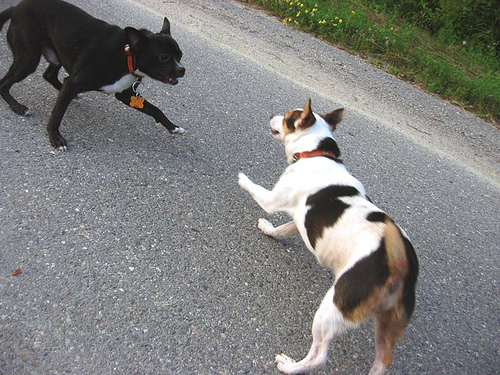

CPU times: user 78.1 ms, sys: 3.07 ms, total: 81.1 ms
Wall time: 87.1 ms


In [0]:
%%time
imageFile = os.path.join(image_dir_path,data.filename.unique()[1])
img = cv2.imread(imageFile)
cv2_imshow(img)

#### Now we have to extract the featuer vector for every image, and we are going to do it with InceptionV3 model.
#### Also by removing the last layer form the model we will the feature vector from the images.

In [0]:
%%time
model = InceptionV3(weights='imagenet')
incp_model_feature = Model(model.input, model.layers[-2].output)

CPU times: user 6.22 s, sys: 453 ms, total: 6.67 s
Wall time: 6.65 s


#### Storing the feature vector to a file so that we need not to calculate it each time.

In [0]:
%%time
imageFeatureFileLocation='/content/drive/My Drive/Colab Notebooks/flickr8k/'
fileName = 'image_feature_train.pkl'

if os.path.isfile(os.path.join(imageFeatureFileLocation,fileName)):
  photo_embeddings_train = load(open(os.path.join(imageFeatureFileLocation,fileName), "rb"))
  print('Train File Loaded : ')
else:
  print('File is not Created.. Please wait.')
  photo_embeddings_train = {};
  for imageName in tqdm(train_df.filename.unique()):
    imageFile = os.path.join(image_dir_path,imageName)
    img = cv2.imread(imageFile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(299,299))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    vector = incp_model_feature.predict(img)
    vector = np.reshape(vector, vector.shape[1])
    photo_embeddings_train[imageName] = vector

    #save the file for later use
    with open(os.path.join(imageFeatureFileLocation,fileName), "wb") as pickel_file:
      pickle.dump(encoding_train, pickel_file)

Train File Loaded : 
CPU times: user 63.1 ms, sys: 43.5 ms, total: 107 ms
Wall time: 166 ms


#### Same thing is done for test as well.

In [0]:
%%time
imageFeatureFileLocation='/content/drive/My Drive/Colab Notebooks/flickr8k/'
fileName = 'image_feature_test.pkl'

if os.path.isfile(os.path.join(imageFeatureFileLocation,fileName)):
  photo_embeddings_test = load(open(os.path.join(imageFeatureFileLocation,fileName), "rb"))
  print('Test File Loaded : ')
else:
  print('File is not Created.. Please wait.')
  photo_embeddings_test = {};
  for imageName in tqdm(test_df.filename.unique()):
    imageFile = os.path.join(image_dir_path,imageName)
    img = cv2.imread(imageFile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(299,299))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    vector = incp_model_feature.predict(img)
    vector = np.reshape(vector, vector.shape[1])
    photo_embeddings_test[imageName] = vector

    #save the file for later use
    with open(os.path.join(imageFeatureFileLocation,fileName), "wb") as pickel_file:
      pickle.dump(photo_embeddings_test, pickel_file)

Test File Loaded : 
CPU times: user 8.34 ms, sys: 6.78 ms, total: 15.1 ms
Wall time: 26.8 ms


In [0]:
%%time
# prepare data for the LSTM
def get_photo_caption_pair(filename):
  input_1 = list()
  input_2 = list()
  output_2 = list()

  photo_feature = photo_embeddings_train[filename]

  for index, rows in train_df[train_df.filename==filename].iterrows():
    seq = [word_index_Mapping[word] for word in rows['caption'].split(' ') if word in word_index_Mapping]

    for i in range(1, len(seq)):
      in_sequence = seq[:i]
      out_sequence = seq[i]

      in_seq = pad_sequences([in_sequence], maxlen=max_caption_length)[0]
      out_seq = to_categorical([out_sequence], num_classes=vocab_size)[0]

      input_1.append(photo_feature)
      input_2.append(in_seq)
      output_2.append(out_seq)
  return np.array(input_1), np.array(input_2), np.array(output_2)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [0]:
def train_generator(number_of_images_per_batch):
  n=0
  while 1:
    for filename in train_df.filename.unique():
      n+=1
      X1, X2, y = get_photo_caption_pair(filename)
      # yield the batch data
      if n==number_of_images_per_batch:
        yield [[X1, X2], y]
        X1 = list()
        X2 = list()
        y = list()
        n=0

## Model Formation :


### Encoder : Our encoder model is out CNN which was the Inception V3 so we are just going to pass the data directly to the model and use a Dropout.


In [0]:
%%time
image_input = Input(shape=(2048,))
x = Dropout(0.4)(image_input)
image_encode = Dense(256, activation='relu')(x)


text_input = Input(shape=(max_caption_length,))
x = Embedding(vocab_size, embedding_dim, mask_zero=True)(text_input)
x = Dropout(0.4)(x)
text_encode = LSTM(256)(x)


decoder_input = add([image_encode, text_encode])
x = Dense(256, activation='relu')(decoder_input)
output = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[image_input, text_input], outputs=output)

CPU times: user 394 ms, sys: 135 ms, total: 530 ms
Wall time: 334 ms


In [0]:
%%time
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 39, 300)      587700      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
%%time
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

CPU times: user 4.55 ms, sys: 0 ns, total: 4.55 ms
Wall time: 5.02 ms


In [0]:
%%time
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

CPU times: user 33 ms, sys: 1.88 ms, total: 34.9 ms
Wall time: 36.1 ms


In [0]:
%%time
model_loss_path = '/content/drive/My Drive/Colab Notebooks/flickr8k/model_loss_list.data'
def load_loss():
  list_of_losses = []
  if not os.path.exists(model_loss_path):
    return list_of_losses
  else:
    with open(model_loss_path, "r") as f:
      for line in f:
        list_of_losses.append(float(line.strip()))
      f.close()
    return list_of_losses

CPU times: user 0 ns, sys: 17 µs, total: 17 µs
Wall time: 33.4 µs


In [0]:
%%time
model_loss_path = '/content/drive/My Drive/Colab Notebooks/flickr8k/model_loss_list.data'
def save_loss(loss):
  list_of_losses = load_loss()
  list_of_losses.append(loss)
  with open(model_loss_path, "w") as f:
    for s in list_of_losses:
        f.write(str(s) +"\n")
    f.close()
  print('Loss Value Saved in file.')

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.9 µs


In [0]:
%%time
model_weights_save_path = '/content/drive/My Drive/Colab Notebooks/flickr8k/model.h5'
if os.path.exists(model_weights_save_path):
  print('Weights Found and Loaded')
  model.load_weights(model_weights_save_path)

Weights Found and Loaded
CPU times: user 24.2 ms, sys: 45.9 ms, total: 70.1 ms
Wall time: 9.89 s


In [0]:
epochs = 10
steps = 2000
num_of_images_per_batch = 5

In [0]:
%%time
for i in range(epochs):
  print('-'*30,'Batch ',i,'-'*30)
  generator = train_generator(num_of_images_per_batch)
  hist = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  current_loss = hist.history['loss'][0]
  save_loss(current_loss)
  print('Saving weights in file.')
  model.save(model_weights_save_path)

Epoch 1/1
2000/2000 [==============================] - 269s 135ms/step - loss: 4.1347
Loss Value Saved in file.
Saving weights in file.
Epoch 1/1
2000/2000 [==============================] - 267s 134ms/step - loss: 3.3772
Loss Value Saved in file.
Saving weights in file.
Epoch 1/1
2000/2000 [==============================] - 267s 134ms/step - loss: 3.0734
Loss Value Saved in file.
Saving weights in file.
Epoch 1/1
2000/2000 [==============================] - 267s 133ms/step - loss: 2.8799
Loss Value Saved in file.
Saving weights in file.
Epoch 1/1
2000/2000 [==============================] - 267s 133ms/step - loss: 2.7349
Loss Value Saved in file.
Saving weights in file.
Epoch 1/1
2000/2000 [==============================] - 264s 132ms/step - loss: 2.6245
Loss Value Saved in file.
Saving weights in file.
Epoch 1/1
2000/2000 [==============================] - 267s 134ms/step - loss: 2.5311
Loss Value Saved in file.
Saving weights in file.
Epoch 1/1
2000/2000 [===========================

In [0]:
%%time
for i in range(epochs):
  print('-'*30,'Batch ',i,'-'*30)
  generator = train_generator(num_of_images_per_batch)
  hist = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  current_loss = hist.history['loss'][0]
  save_loss(current_loss)
  print('Saving weights in file.')
  model.save(model_weights_save_path)

------------------------------ Batch  0 ------------------------------
Epoch 1/1
2000/2000 [==============================] - 239s 119ms/step - loss: 2.3861
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  1 ------------------------------
Epoch 1/1
2000/2000 [==============================] - 236s 118ms/step - loss: 2.2826
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  2 ------------------------------
Epoch 1/1
2000/2000 [==============================] - 235s 118ms/step - loss: 2.2276
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  3 ------------------------------
Epoch 1/1
2000/2000 [==============================] - 235s 118ms/step - loss: 2.1843
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  4 ------------------------------
Epoch 1/1
2000/2000 [==============================] - 235s 118ms/step - loss: 2.1475
Loss Value Save

In [0]:
epochs = 10
steps = 1000
num_of_images_per_batch = 10
model.optimizer = optimizers.Adam(learning_rate=0.0001)

In [0]:
%%time
for i in range(epochs):
  print('-'*30,'Batch ',i,'-'*30)
  generator = train_generator(num_of_images_per_batch)
  hist = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  current_loss = hist.history['loss'][0]
  save_loss(current_loss)
  print('Saving weights in file.')
  model.save(model_weights_save_path)

------------------------------ Batch  0 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 138s 138ms/step - loss: 2.0517
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  1 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 137s 137ms/step - loss: 1.9554
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  2 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 137s 137ms/step - loss: 1.8715
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  3 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 138s 138ms/step - loss: 1.8237
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  4 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 137s 137ms/step - loss: 1.7750
Loss Value Save

In [0]:
%%time
for i in range(epochs):
  print('-'*30,'Batch ',i,'-'*30)
  generator = train_generator(num_of_images_per_batch)
  hist = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  current_loss = hist.history['loss'][0]
  save_loss(current_loss)
  print('Saving weights in file.')
  model.save(model_weights_save_path)

------------------------------ Batch  0 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 136s 136ms/step - loss: 1.5757
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  1 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 137s 137ms/step - loss: 1.5537
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  2 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 137s 137ms/step - loss: 1.5268
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  3 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 137s 137ms/step - loss: 1.5058
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  4 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 137s 137ms/step - loss: 1.4856
Loss Value Save

In [0]:
%%time
for i in range(epochs):
  print('-'*30,'Batch ',i,'-'*30)
  generator = train_generator(num_of_images_per_batch)
  hist = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  current_loss = hist.history['loss'][0]
  save_loss(current_loss)
  print('Saving weights in file.')
  model.save(model_weights_save_path)

------------------------------ Batch  0 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 223s 223ms/step - loss: 1.5461
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  1 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 221s 221ms/step - loss: 1.4496
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  2 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 220s 220ms/step - loss: 1.4229
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  3 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 218s 218ms/step - loss: 1.4064
Loss Value Saved in file.
Saving weights in file.
------------------------------ Batch  4 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 216s 216ms/step - loss: 1.3837
Loss Value Save

In [0]:
%%time
for i in range(epochs):
  print('-'*30,'Batch ',i,'-'*30)
  generator = train_generator(num_of_images_per_batch)
  hist = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  #current_loss = hist.history['loss'][0]
  #save_loss(current_loss)
  #print('Saving weights in file.')
  #model.save(model_weights_save_path)

------------------------------ Batch  0 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 221s 221ms/step - loss: 1.3149
------------------------------ Batch  1 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 219s 219ms/step - loss: 1.3126
------------------------------ Batch  2 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 218s 218ms/step - loss: 1.3025
------------------------------ Batch  3 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 217s 217ms/step - loss: 1.2982
------------------------------ Batch  4 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 217s 217ms/step - loss: 1.2883
------------------------------ Batch  5 ------------------------------
Epoch 1/1
1000/1000 [==============================] - 220s 220ms/step - loss: 1.2815
------------------------------ Batch  6 ------------------

In [0]:
model.save(model_weights_save_path)

## Creating a function to predict caption from test images : 

In [0]:
%%time
# prepare data for the LSTM
def get_caption_for_photo(filename):
  imageFile = os.path.join(image_dir_path,filename)
  img = cv2.imread(imageFile)
  cv2_imshow(img)
  photo_feature = np.reshape(photo_embeddings_test[filename],(1,2048))
  in_text = 'startSeq'
  for i in range(1, max_caption_length):
    seq = [word_index_Mapping[w] for w in in_text.split() if w in word_index_Mapping]
    in_seq = pad_sequences([seq], maxlen=max_caption_length)
    inputs = [photo_feature,in_seq]
    yhat = model.predict(x=inputs, verbose=0)
    yhat = np.argmax(yhat)
    word = index_word_Mapping[yhat]
    in_text += ' ' + word
    if word == 'endSeq':
      break

  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 11.7 µs


## Lets Plot The Loss for our Model : 

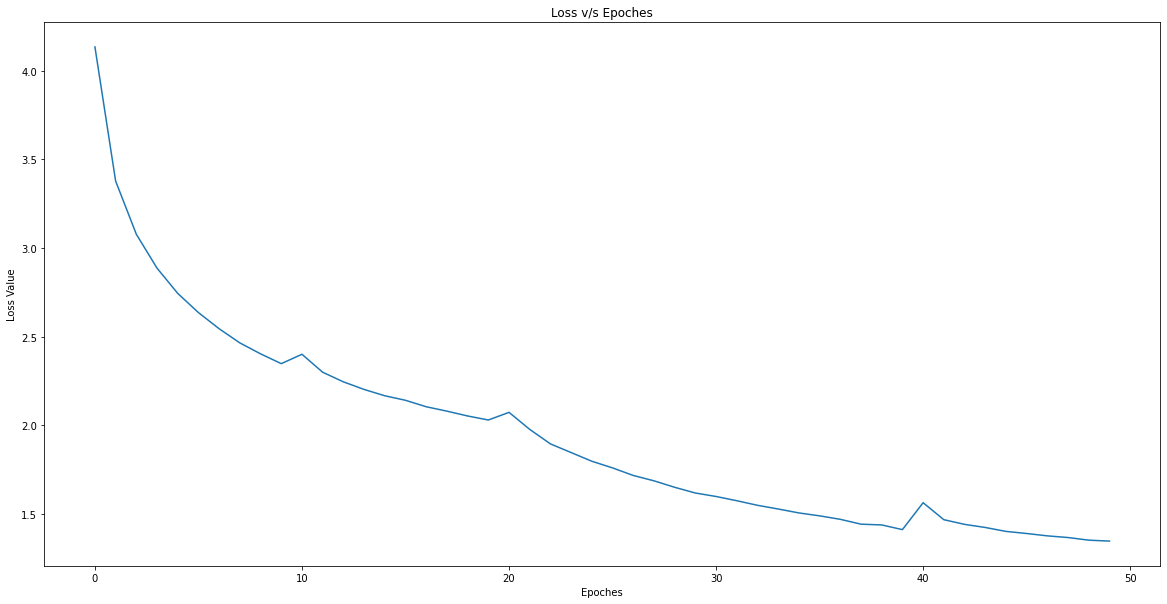

In [0]:
loss_values = load_loss()
plt.figure(figsize=(20,10))
plt.plot(loss_values)
plt.xlabel('Epoches')
plt.ylabel('Loss Value')
plt.title('Loss v/s Epoches')
plt.show()

## Let's see some relevant predictions : 

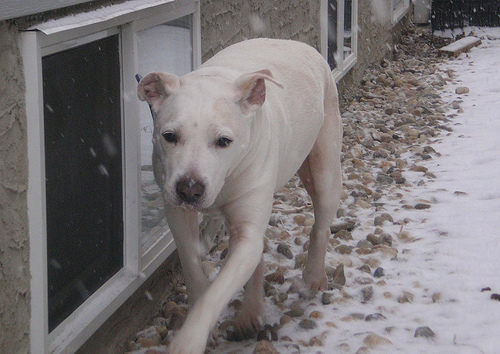



 a dog is running through a grassy area


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

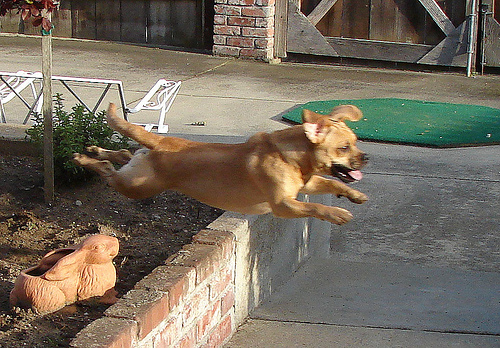



 a dog jumps to catch a toy


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

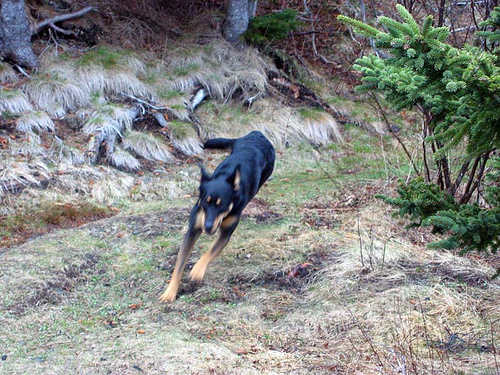



 a black dog with a red collar walks through the grass


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

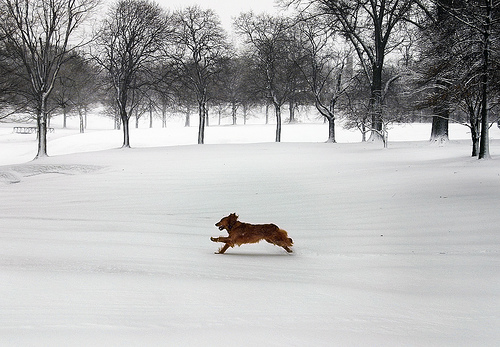



 two dogs are running through snow away from the camera


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

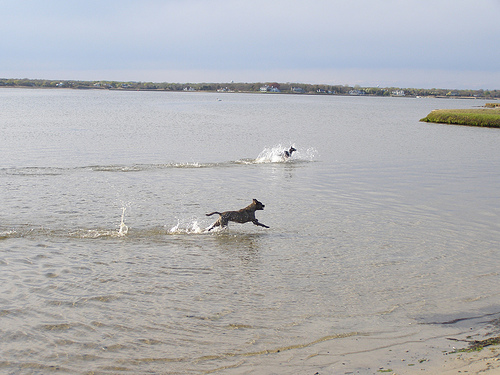



 a dog is running through the water


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

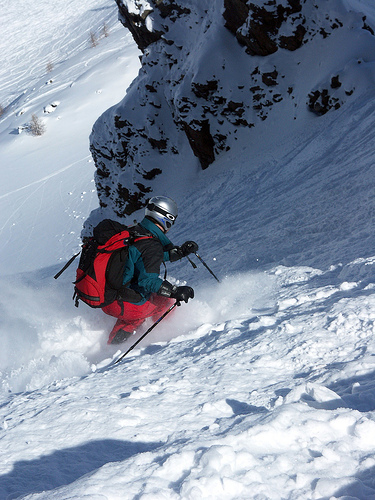



 a skier pauses on a mountaintop


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

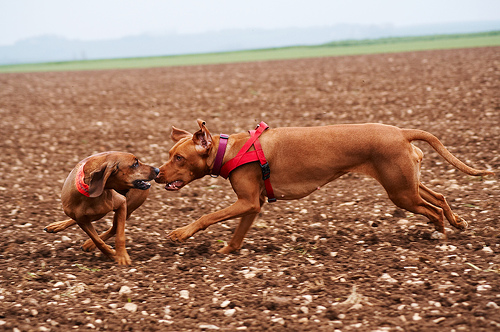



 a dog is running during a dirty road


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

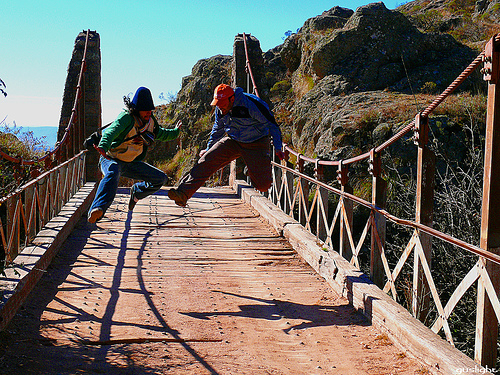



 a man in a hoodie skateboards in front of a blue sky and building shot from below


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

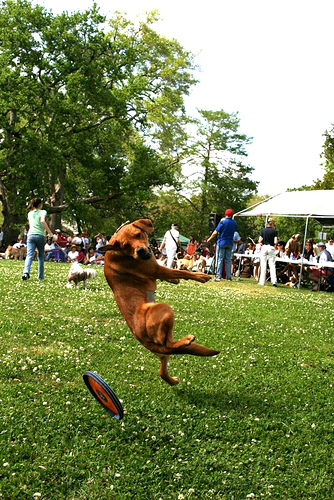



 a dog is jumping up to catch a red ball


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

## Now, Let's see some totally irrelevant predictions :

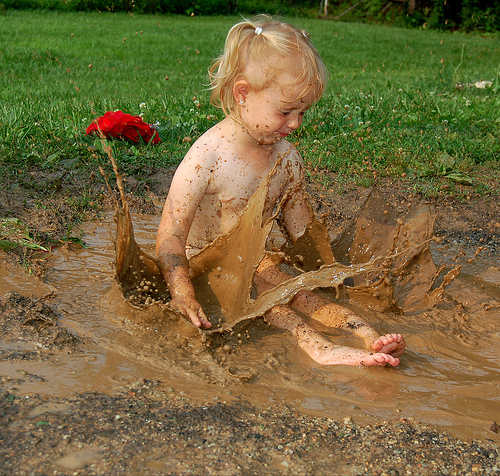



 a boy in a blue shirt is walking on a beach with a surfboard


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

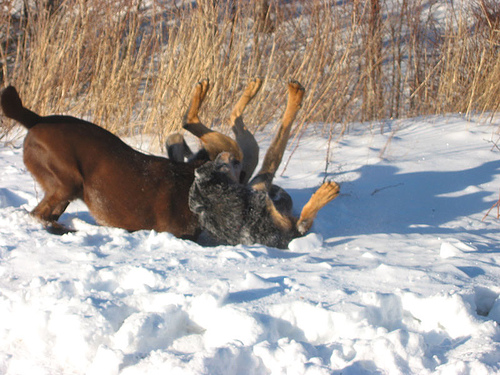



 a dog is running through a desert


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

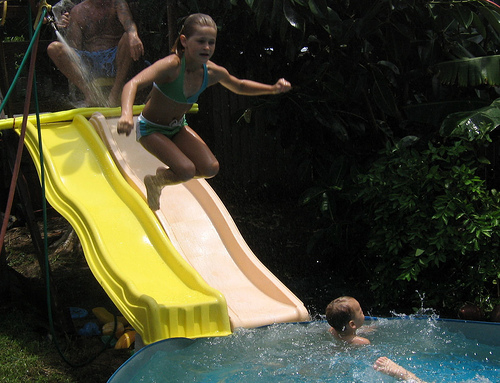



 a boy in a yellow guard is playing in a stream


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

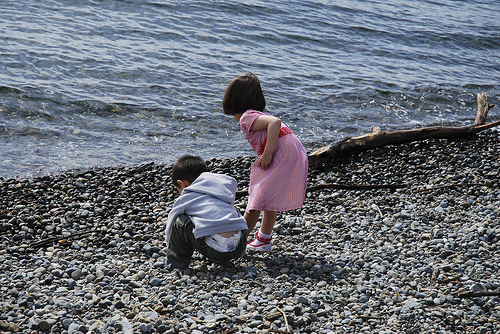



 a girl in a brown shirt is moving on a rocky shore looking toward the water


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

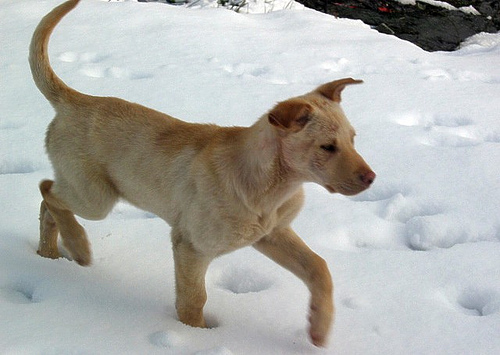



 a dog is jumping through the air in a grassy field


In [0]:
caption = get_caption_for_photo(test_df.filename.unique()[random.randint(1,1000)])
print('\n\n',caption)

## References : 

https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

https://github.com/hlamba28/Automatic-Image-Captioning

https://www.kaggle.com/shadabhussain/flickr8k

https://www.tensorflow.org/guide/keras/functional